In [103]:

from scipy.stats import multivariate_normal, gaussian_kde
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:

d1 = io.loadmat("data.mat")['d1']             # samples from GMM with two mixtures
d2_1 = io.loadmat("data.mat")['d2_1']
d2_2 = io.loadmat("data.mat")['d2_2']

d1.shape, d2_1.shape, d2_2.shape


# initial Gaussian mixture label assignment

In [213]:

def mean_and_cov(data):
#     mu = np.sum(data,axis=0)
    mu=np.mean(data,axis=0)
    cov = np.dot((data-mu).T,data-mu)/(len(data)-1)
    return mu, cov

def norm_dist_est(mu, cov, data):
    return multivariate_normal(mu, cov).pdf(data)

def log_likelihood_est(mu,cov,data):
    return multivariate_normal(mu, cov).logpdf(data)

# 2x1 observation vector cols
data = d1.transpose()
# initial mixing parameter
rho = 0.5
# initialize Gaussian mixture label assignment, class 1 or 2
n_samples = d1.shape[1]
label = np.concatenate((np.ones(n_samples//2), 2 * np.ones(n_samples//2)))

for _ in range(5):
    # group samples by label and estimate mu and cov
    class1 = data[label==1]
    class2 = data[label==2]

    mu1, mu2 = class1.mean(axis=0), class2.mean(axis=0)
    cov1 = np.dot((class1-mu1).T,class1-mu1)/(len(class1)-1)
    cov2 = np.dot((class2-mu2).T,class2-mu2)/(len(class2)-1)
    
    ## Expectation
    # calculate posterior probability
    p1 = rho*norm_dist_est(mu1,cov1,data)
    p2 = (1-rho)*norm_dist_est(mu2,cov2,data)
    assigned_samples = p1/(p1+p2)
    
    # find the ratio of predicted class assignments 
    N1 = np.sum(assigned_samples)
    N2 = n_samples - N1
    
    # update mixing param
    rho = N1/n_samples

    ## Maximization
    samples = assigned_samples.reshape(n_samples,1)
    
    # use posterior to estimate new mu and cov 
    mu1 = np.sum(data*samples,axis=0)/N1
    mu2 = np.sum(data*(1-samples),axis=0)/N2

    cov1 = np.dot((samples*(data-mu1)).T,data-mu1)/N1
    cov2 = np.dot(((1-samples)*(data-mu2)).T,data-mu2)/N2
    
    # calculate log likelihood and compare to assign new class labels
    likelihood1, likelihood2 = log_likelihood_est(mu1,cov1,data), log_likelihood_est(mu2,cov2,data)
    label = np.array([1 if a>b else 2 for a,b in list(zip(likelihood1, likelihood2))])
    
rho, mu1, mu2, cov1, cov2



(0.7102172796661677,
 array([ 0.01040563, -0.08078861]),
 array([ 4.24015107, -3.30609828]),
 array([[0.98328111, 0.25403771],
        [0.25403771, 0.94421325]]),
 array([[ 3.12120357, -0.02789449],
        [-0.02789449,  7.43720042]]))

# parzen window density est

Based on probability density surface plots, x=[1,-2] belongs to class 1


In [379]:

def gaussian_kernel(delta_x):
    w = 1/(0.2*np.sqrt(2*np.pi))
    e = (-(delta_x/hn)**2)/2
    return w*np.exp(e)

def class_density(w, region):
    density = []

    for pt in region: 
        delta_x = np.array([pt-x_i for x_i in w])
        p_x = gaussian_kernel(delta_x)
        estimate = np.sum(p_x,axis=0)/100
        density.append(estimate)

    return np.array(density)


In [380]:

w1, w2 = d2_1.transpose(), d2_2.transpose()
# define Parzen window
n = 100
h1 = 2
hn = h1/np.sqrt(n)

x, y = np.meshgrid(np.arange(-4, 8, 0.1), np.arange(-4, 8, 0.1))
region = np.column_stack([x.ravel(), y.ravel()])

p_w1 = class_density(w1, region)
p_w2 = class_density(w2, region)


<AxesSubplot:ylabel='Density'>

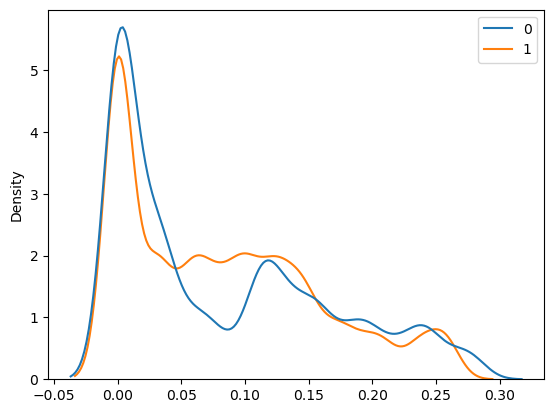

In [381]:

sns.kdeplot(p_w1)


<AxesSubplot:ylabel='Density'>

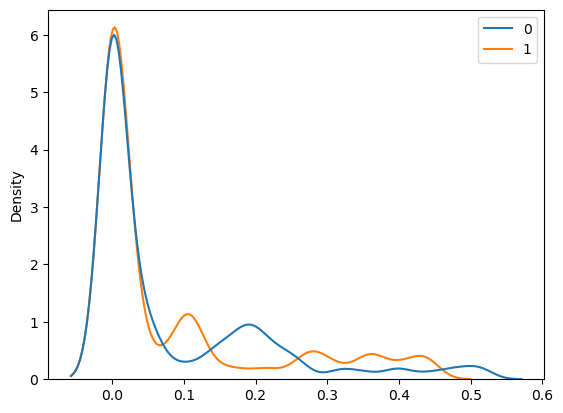

In [382]:

sns.kdeplot(p_w2)



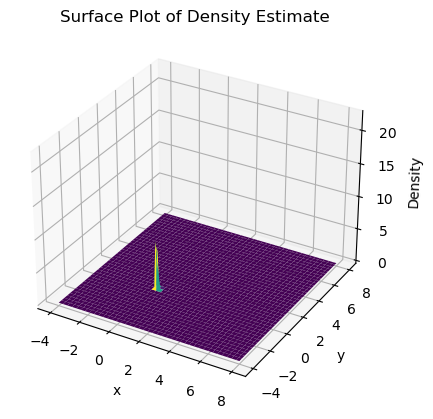

In [468]:

## w1

# estimate prob density using a Gaussian kernel
kde1 = gaussian_kde(p_w1.T)
kde2 = gaussian_kde(p_w2.T)

n_slices = int((8-(-4))/0.1)

x,y = np.linspace(-4, 8, n_slices), np.linspace(-4, 8, n_slices)
X, Y = np.meshgrid(x, y)

region = np.column_stack([X.ravel(), Y.ravel()])

Z1 = np.reshape(kde1(region.transpose()).T, X.shape)
Z2 = np.reshape(kde2(region.transpose()).T, X.shape)

# plot 3d surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z1, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
ax.set_title('Surface Plot of Density Estimate')

plt.show()



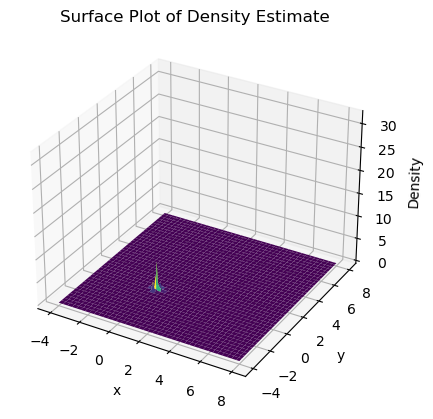

In [469]:

## w2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z2, cmap='viridis')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
ax.set_title('Surface Plot of Density Estimate')

plt.show()


# classification vectors

Based on classification vector, sample belongs to class 1

In [467]:

sig2 = (0.2)**2

def norm_data(x):
    return (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))

x1, x2 = norm_data(w1), norm_data(w2)
d1, d2 = x1, x2

net1 = [np.dot(d1[i].T, x1[i]) for i in range(len(w1))]
net2 = [np.dot(d2[i].T, x1[i]) for i in range(len(w1))]

window = lambda x: np.exp((x-1)/sig2)

activation1 = [window(x) for x in net1]
activation2 = [window(x) for x in net2]

g_i = lambda act,i: np.sum(act[:i]) 

classification = []

for i in range(100):
    g1 = g_i(activation1, i)
    g2 = g_i(activation2, i)
    
    if g1 > g2:
        classification.append(1)
    else:
        classification.append(2)
